# KNN Cancer Detector
*22-11-2017*

This was a project that grew out of my studies at GA. After learning about K nearest neighbours and finding the wisconsin breast cancer [dataset](https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/) I thought I would apply what I learned to a real life scenario. What follows is the full code from that idea. 

Usually I will just insert the most interesting bits of code but in this case I wanted to display my full thinking as clearly as possible. I have tried to document as I go along and make my expression as simple as possible to understand.

Primarily I have focussed on the evaluation of the model produced using a variety of tools such as the classification report and the ROC curve.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

In [2]:
np.set_printoptions(precision=4)

plt.style.use('fivethirtyeight')

column_names = ['id',
                'clump_thickness',
                'cell_size_uniformity',
                'cell_shape_uniformity',
                'marginal_adhesion',
                'single_epithelial_size',
                'bare_nuclei',
                'bland_chromatin',
                'normal_nucleoli',
                'mitoses',
                'class']

In [3]:
bcw = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data', 
                  names=column_names)

bcw['bare_nuclei'] = bcw.bare_nuclei.map(lambda x: int(x) if not x == '?' else np.nan)
bcw.dropna(inplace=True)

Here the production of a correlation heatmap seems like a good beginning point as it will show the features of the data and illustrate the extent to which they relate to each other. This is achieved through the `.corr()` function being called on the dataframe. 

Once a correlation matrix has been produced it is a simple matter of plugging into the pre-written boiler plate heatmap plot (I wrote this once and liked it so much I have used it ever since). 

This gives the heatmap plot below.

In [4]:
correlation_matrix = bcw.corr()

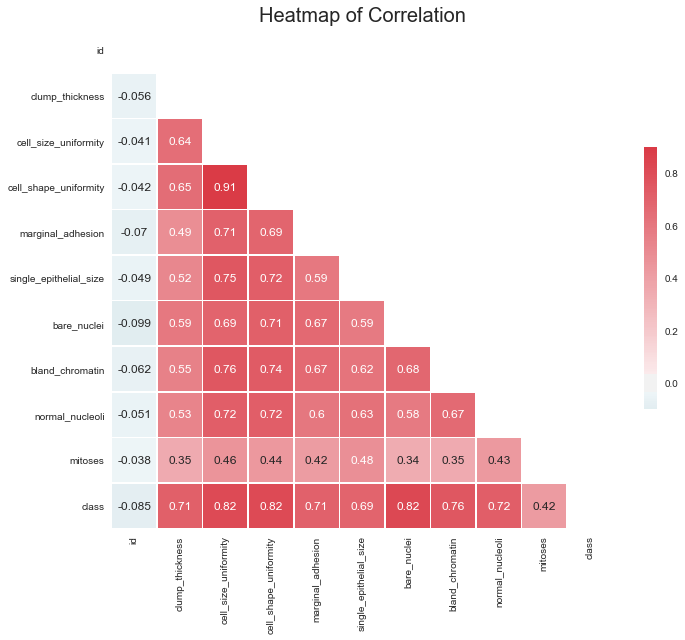

In [5]:
sns.set(style="white")
# Generate a mask for the upper triangle
mask = np.zeros_like(correlation_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.title('Heatmap of Correlation', size=20)
plt.savefig('Correlation_Heatmap.png')
plt.show()

In [6]:
y = bcw['class'].map(lambda x: 1 if x == 4 else 0)
X = bcw.iloc[:, 1:-1]

For model evaluation it is obvious that a train-test split of the data will be necessary. This will allow us to train the KNN model on one set of data and evaluate on different data. 

This is standard practice in data science for the intuitively obvious reason that testing a model on the same data you trained it on is going to lead to artificially high evaluation scores.

Having a relatively small dataset is a major drawback to this overall analysis and no amount of clever data science will make up for this weakness however it is important to train-test split in all circumstances regardless of the number of data.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=25, p=2,
           weights='uniform')

A baseline score - which can be said to be the number of accurate predictions that would be made if guesswork were applied - is calculated and shown. 

A model would be successful if it improved on this score and so it is important to know. Of course an actually successful model will improve on baseline *significantly*.

In [1]:
print 'Baseline:\t', 1. - np.mean(y_test)
print '\n'
print 'Model score:\t', knn.score(X_test, y_test)

Baseline:	

NameError: name 'np' is not defined

This cell is the most important. It shows the classification reports and gives a clear indication of the model's performance. 

Here it is important to think about thresholds and false negatives. 

Consider that this is a dataset that relates to Cancer detection. In such circumstances it can be seen that the truly worst situation is the model predicting someone as 'all clear' when in fact they do have cancer. This is a so-called 'false negative'. 

From the first classification report it can be seen that the model returned 6 people as healthy when in fact the true label was 'cancer'. This is far too high. From this the decision was taken to adjust the thresholds to bias towards 'cancer', that is, to take a 'better safe than sorry' approach. This reduced the false negative rate to just a single instance. 

In [9]:
# predicted test class:
y_pred = knn.predict(X_test)

# predicted test probability:
y_pp = knn.predict_proba(X_test)

# Let's say again that we are predicting cancer based on some kind of detection measure, as before.
# Accuracy Score
conmat = np.array(confusion_matrix(y_test, y_pred, labels=[1,0]))
classification_report = classification_report(y_test, y_pred)
print '\n'
print classification_report

confusion = pd.DataFrame(conmat, index=['is_cancer', 'is_healthy'],
                         columns=['predicted_cancer','predicted_healthy'])
print "50/50 Thresholds: \n", confusion
print '\n'
# Get the predicted probability vector and explicitly name the columns:
Y_pp = pd.DataFrame(knn.predict_proba(X_test), columns=['class_0_pp','class_1_pp'])
Y_pp.head(10)

Y_pp['pred_class_thresh10'] = [1 if x >= 0.10 else 0 for x in Y_pp.class_1_pp.values]
Y_pp.head(20)

conmat = np.array(confusion_matrix(y_test, Y_pp.pred_class_thresh10.values, labels=[1,0]))

confusion = pd.DataFrame(conmat, index=['is_cancer', 'is_healthy'],
                         columns=['predicted_cancer','predicted_healthy'])
print "Changed Thresholds: \n", confusion
print '\n'



             precision    recall  f1-score   support

          0       0.96      0.99      0.97       152
          1       0.97      0.92      0.94        74

avg / total       0.96      0.96      0.96       226

50/50 Thresholds: 
            predicted_cancer  predicted_healthy
is_cancer                 68                  6
is_healthy                 2                150


Changed Thresholds: 
            predicted_cancer  predicted_healthy
is_cancer                 73                  1
is_healthy                 6                146




The final step was to produce a ROC curve. This is a curve that shows the true positive (recall) rate as the area under the curve. If this area is equal to one then the positive predictions are totally perfect and no false positives exist. The dotted line on the graph shows the baseline (0.5) rate which relates to a model which closely resembles guess work.

It can be seen that the model created gives a ROC of 0.99 which is clearly very close to perfect. 

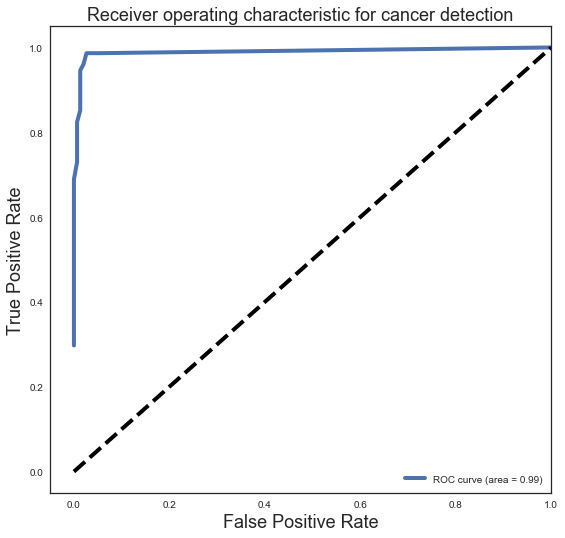



fpr	tpr	threshold
[[ 0.      0.2973  1.    ]
 [ 0.      0.5676  0.96  ]
 [ 0.      0.6892  0.92  ]
 [ 0.0066  0.7297  0.88  ]
 [ 0.0066  0.8108  0.84  ]
 [ 0.0066  0.8243  0.8   ]
 [ 0.0132  0.8514  0.72  ]
 [ 0.0132  0.8784  0.68  ]
 [ 0.0132  0.9189  0.52  ]
 [ 0.0132  0.9459  0.48  ]
 [ 0.0197  0.9595  0.44  ]
 [ 0.0263  0.9865  0.36  ]
 [ 0.0395  0.9865  0.2   ]
 [ 0.0526  0.9865  0.04  ]
 [ 1.      1.      0.    ]]


In [10]:
# For class 1, find the area under the curve
fpr, tpr, threshold = roc_curve(y_test, Y_pp.class_1_pp)
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for cancer detection', fontsize=18)
plt.legend(loc="lower right")
plt.savefig('ROC_plot.png')
plt.show()

print '\n'
print 'fpr\t', 'tpr\t', 'threshold'
print np.array(zip(fpr,tpr,threshold))